In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
import keras.callbacks as cb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, Concatenate, GlobalAveragePooling2D, UpSampling2D
from PIL import Image

import keras
import tensorflow
import tensorflow.compat.v1 as tf

import numpy as np
import pandas as pd
import imageio
import cv2
import pprint
import os
import re
import h5py
import PIL

import src.model as my_model
import src.pcam_loader as data
import src.adaptive_model as am
import src.dagm_loader as dagm

Using TensorFlow backend.


In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    result = true_positives / (possible_positives + K.epsilon())
    return result


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    result = true_positives / (predicted_positives + K.epsilon())
    return result


def f1_score_metrics(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))


def f1_score_evaluate(precision, recall):
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# config = tf.ConfigProto(device_count={"CPU": 8})
# tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4776444006325732520
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5750627894205695671
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



In [4]:
# x_train, y_train = dagm.load_dataset('Train', 'data')
# x_test, y_test = dagm.load_dataset('Test', 'data')

# x_valid_length = round(len(x_test)/2)

# x_valid = np.array(x_test[x_valid_length:])
# x_test = np.array(x_test[:x_valid_length])

# y_valid = y_test[x_valid_length:]
# y_test = y_test[:x_valid_length]

In [5]:
dataset = data.load_data()
x_train, y_train, meta_train =  dataset[0]
x_valid, y_valid, meta_valid =  dataset[1]
x_test, y_test, meta_test =  dataset[2]

y_train = np.array(y_train[:])
y_train = y_train.reshape(-1, 1)
y_valid = np.array(y_valid[:])
y_valid = y_valid.reshape(-1, 1)
y_test = np.array(y_test[:])
y_test = y_test.reshape(-1, 1)

C:\Users\matho\anaconda3\lib\site-packages\keras\utils\io_utils.py:60: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


In [6]:
batch_size = 10
epochs = 10
num_classes = 2
shape = x_train[0].shape
results = {}

In [7]:
def train(model, x_train, y_train, x_valid, y_valid, model_name):
    callbacks = [
        cb.callbacks.ModelCheckpoint(model_name, save_best_only=True)
    #     cb.callbacks.EarlyStopping(monitor = 'val_loss'),
    #     cb.callbacks.CSVLogger('model.csv', separator=',', append=False),
    #     cb.tensorboard_v1.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    ]

    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=[
                      tensorflow.keras.metrics.Precision(),
                      'accuracy',
                      tensorflow.keras.metrics.Recall(),
                      tensorflow.keras.metrics.TruePositives(),
                      tensorflow.keras.metrics.FalsePositives(),
                      tensorflow.keras.metrics.FalseNegatives()
                          ])

    history = model.fit(
        x_train,
        to_categorical(y_train),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_valid, to_categorical(y_valid)),
        shuffle='batch',
        callbacks=callbacks,
        use_multiprocessing=True
    )
    return history

In [8]:
counter = 0
def evaluate(model, x_test, y_test, history, model_name, results, counter):

    test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
    f1_score = f1_score_evaluate(test_eval[2], test_eval[3])
    results[model_name] = {'Precision:': test_eval[1],
                            'Accuracy:': test_eval[2],
                            'Recall:': test_eval[3],
                            'F1_score': f1_score}

    import matplotlib.pyplot as plt
    try:            
        graf_value= 'accuracy'
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try: 
        graf_value= 'precision'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'recall'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'true_positives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'false_positives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'false_negatives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
        
    counter += 1

## BackPropagation

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 607s 2ms/step - loss: 0.2681 - precision: 0.8508 - accuracy: 0.8891 - recall: 0.8508 - true_positives: 114544.7578 - false_positives: 16535.1309 - false_negatives: 16535.1309 - val_loss: 0.4193 - val_precision: 0.8853 - val_accuracy: 0.8209 - val_recall: 0.8853 - val_true_positives: 246559.0938 - val_false_positives: 31974.7969 - val_false_negatives: 31974.7969
Epoch 2/10
262144/262144 [==============================] - 593s 2ms/step - loss: 0.1968 - precision: 0.8931 - accuracy: 0.9229 - recall: 0.8931 - true_positives: 380842.9375 - false_positives: 45148.9414 - false_negatives: 45148.9414 - val_loss: 0.4203 - val_precision: 0.8984 - val_accuracy: 0.8100 - val_recall: 0.8984 - val_true_positives: 515161.8125 - val_false_positives: 58284.0742 - val_false_negatives: 58284.0742
Epoch 3/10
262144/262144 [==============================] - 593s 2ms/step - loss: 0.1743 - precision:

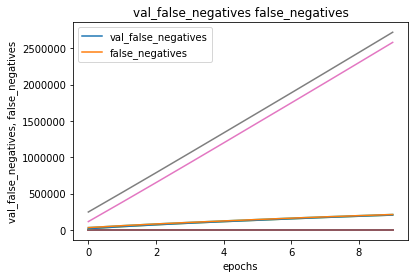

In [9]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation316.h5'

layers = am.unet_layer(input_layer, 3, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)


Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 584s 2ms/step - loss: 0.2647 - precision_1: 0.8585 - accuracy: 0.8920 - recall_1: 0.8585 - true_positives_1: 115298.2188 - false_positives_1: 15781.7285 - false_negatives_1: 15781.7285 - val_loss: 0.4569 - val_precision_1: 0.8852 - val_accuracy: 0.7737 - val_recall_1: 0.8852 - val_true_positives_1: 246511.6094 - val_false_positives_1: 32022.4141 - val_false_negatives_1: 32022.4141
Epoch 2/10
262144/262144 [==============================] - 580s 2ms/step - loss: 0.2092 - precision_1: 0.8896 - accuracy: 0.9179 - recall_1: 0.8896 - true_positives_1: 379363.1250 - false_positives_1: 46628.9219 - false_negatives_1: 46628.9219 - val_loss: 0.4148 - val_precision_1: 0.8954 - val_accuracy: 0.8293 - val_recall_1: 0.8954 - val_true_positives_1: 513433.4375 - val_false_positives_1: 60012.4180 - val_false_negatives_1: 60012.4180
Epoch 3/10
262144/262144 [==============================] - 5

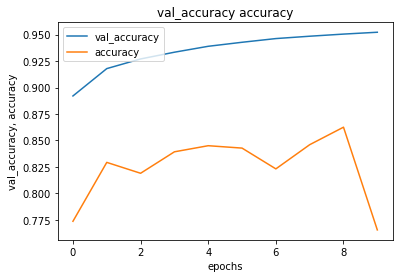

In [10]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation516.h5'

layers = am.unet_layer(input_layer, 5, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)


Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 595s 2ms/step - loss: 0.2742 - precision_2: 0.8468 - accuracy: 0.8861 - recall_2: 0.8468 - true_positives_2: 114194.7109 - false_positives_2: 16885.3281 - false_negatives_2: 16885.3281 - val_loss: 0.4593 - val_precision_2: 0.8806 - val_accuracy: 0.7895 - val_recall_2: 0.8806 - val_true_positives_2: 245257.1250 - val_false_positives_2: 33276.7930 - val_false_negatives_2: 33276.7930
Epoch 2/10
262144/262144 [==============================] - 593s 2ms/step - loss: 0.2084 - precision_2: 0.8870 - accuracy: 0.9183 - recall_2: 0.8870 - true_positives_2: 378296.0625 - false_positives_2: 47696.1445 - false_negatives_2: 47696.1445 - val_loss: 0.5767 - val_precision_2: 0.8911 - val_accuracy: 0.7348 - val_recall_2: 0.8911 - val_true_positives_2: 510957.3750 - val_false_positives_2: 62488.6484 - val_false_negatives_2: 62488.6484
Epoch 3/10
262144/262144 [==============================] - 5

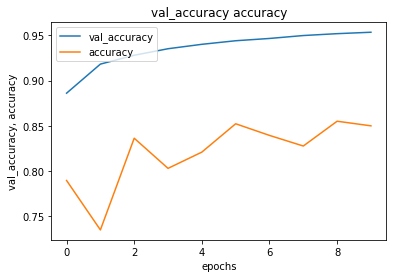

In [11]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation716.h5'

layers = am.unet_layer(input_layer, 7, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

## Gabor filters

In [12]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor516.h5'

# layers = am.gabor_layer(input_layer, 5, 16)

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model 
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

In [13]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor716.h5'

# layers = am.gabor_layer(input_layer, 7, 16)

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model 
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

In [14]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor916.h5'

# layers = am.gabor_layer(input_layer, 9, 16) 

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model 
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

In [15]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor516.h5'

# layers = am.gabor_layer(input_layer, 5, 16)

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

In [16]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor716.h5'

# layers = am.gabor_layer(input_layer, 7, 16)

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

In [17]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor916.h5'

# layers = am.gabor_layer(input_layer, 9, 16)

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)


In [18]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor516.h5'

# layers = am.gabor_layer(input_layer, 5, 16)

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

In [19]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor716.h5'

# layers = am.gabor_layer(input_layer, 7, 16)

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

In [20]:
# # Input layer with shape of data
# input_layer = am.input_layer(shape)
# model_name = 'adaptive_gabor916.h5'

# layers = am.gabor_layer(input_layer, 9, 16)

# # Use Unet architecture as main model
# outputs_layer = am.unet_model(layers)

# # Output layer
# outputs_layer = am.flatten_layer(outputs_layer)
# outputs_layer = am.output_layer(outputs_layer)

# # Define model
# model = am.define_model(input_layer, outputs_layer)

# # Add filters from gabor function
# weights, filters = am.gabor_filter(model)
# model.layers[1].set_weights(weights)

# history = train(model, x_train, y_train, x_valid, y_valid, model_name)
# evaluate(model, x_test, y_test, history, model_name, results, counter)
# pprint.pprint(results)

## Autoencoder

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 942s 4ms/step - loss: 0.3203 - precision_3: 0.8102 - accuracy: 0.8632 - recall_3: 0.8102 - true_positives_3: 110465.4141 - false_positives_3: 20614.5039 - false_negatives_3: 20614.5039 - val_loss: 0.4603 - val_precision_3: 0.8600 - val_accuracy: 0.8056 - val_recall_3: 0.8600 - val_true_positives_3: 239521.6719 - val_false_positives_3: 39012.2344 - val_false_negatives_3: 39012.2344
Epoch 2/10
262144/262144 [==============================] - 939s 4ms/step - loss: 0.2463 - precision_3: 0.8689 - accuracy: 0.9019 - recall_3: 0.8689 - true_positives_3: 370597.8125 - false_positives_3: 55394.0195 - false_negatives_3: 55394.0195 - val_loss: 0.4609 - val_precision_3: 0.8759 - val_accuracy: 0.8000 - val_recall_3: 0.8759 - val_true_positives_3: 502249.3438 - val_false_positives_3: 71196.7031 - val_false_negatives_3: 71196.7031
Epoch 3/10
262144/262144 [==============================] - 9

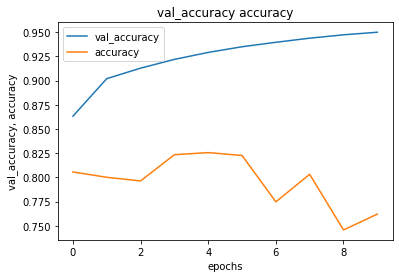

In [21]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder316.h5'

layers = am.encoder_layer(input_layer, 3, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 1033s 4ms/step - loss: 0.3788 - precision: 0.7816 - accuracy: 0.8342 - recall: 0.7816 - true_positives: 106376.6406 - false_positives: 24703.1523 - false_negatives: 24703.1523 - val_loss: 0.8395 - val_precision: 0.8097 - val_accuracy: 0.4148 - val_recall: 0.8097 - val_true_positives: 225397.0625 - val_false_positives: 53136.7852 - val_false_negatives: 53136.7852
Epoch 2/10
262144/262144 [==============================] - 1011s 4ms/step - loss: 0.2922 - precision: 0.8130 - accuracy: 0.8798 - recall: 0.8130 - true_positives: 347264.8125 - false_positives: 78726.9219 - false_negatives: 78726.9219 - val_loss: 1.2258 - val_precision: 0.8228 - val_accuracy: 0.5434 - val_recall: 0.8228 - val_true_positives: 471772.9688 - val_false_positives: 101673.0547 - val_false_negatives: 101673.0547
Epoch 3/10
262144/262144 [==============================] - 1017s 4ms/step - loss: 0.2742 - preci

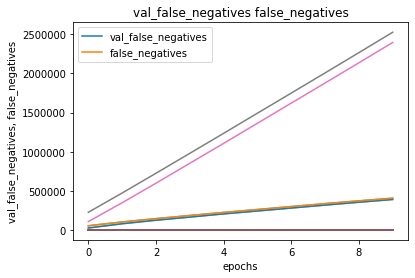

In [9]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder516.h5'


layers = am.encoder_layer(input_layer, 5, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 1077s 4ms/step - loss: 0.4480 - precision_1: 0.7478 - accuracy: 0.7969 - recall_1: 0.7478 - true_positives_1: 101429.1953 - false_positives_1: 29650.7422 - false_negatives_1: 29650.7422 - val_loss: 0.5462 - val_precision_1: 0.7930 - val_accuracy: 0.7288 - val_recall_1: 0.7930 - val_true_positives_1: 220856.5625 - val_false_positives_1: 57677.1602 - val_false_negatives_1: 57677.1602
Epoch 2/10
262144/262144 [==============================] - 1112s 4ms/step - loss: 0.2911 - precision_1: 0.8137 - accuracy: 0.8789 - recall_1: 0.8137 - true_positives_1: 347521.5625 - false_positives_1: 78470.3047 - false_negatives_1: 78470.3047 - val_loss: 0.5518 - val_precision_1: 0.8282 - val_accuracy: 0.7119 - val_recall_1: 0.8282 - val_true_positives_1: 474900.0000 - val_false_positives_1: 98545.7344 - val_false_negatives_1: 98545.7344
Epoch 3/10
262144/262144 [==============================] -

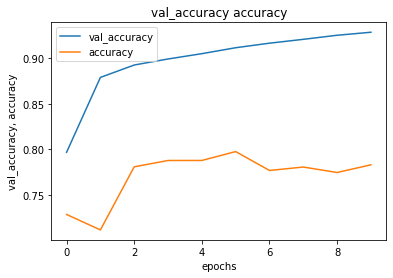

In [10]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder716.h5'

layers = am.encoder_layer(input_layer, 7, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)